# Two-body problem: Analysis notebook

## Name: Males-Araujo Yorlan

This notebook contains the solutions for the remaining questions of the exam.

### Module design

We present both the directory and source code structure of **Atramenta**, our package for simulating planet orbits around a black hole.

#### Directory structure

It is outlined as follows:

```
atramenta/
├── atramenta/
│   ├── __init__.py
│   ├── orbits.py          # Source code
│   └── test_orbits.py     # Unit tests
│
├── analysis.ipynb         # Comparing and analyzing results
│
├── outputfolder/
│    ├── *.h5              # Orbital history
│    └── *.gif             # Animations
│   
├── README.md              # Brief usage instructions
└── setup.py          
```

#### Code structure (`orbits.py`)

The code is organized into three main classes: `OrbitBirther` (initializer), `CelestialSeer` (integrator), and `ChronoPainter` (animator). The first two are responsible for simulating orbits, and the last one is for visualizing them. Not all methods or arguments are shown, only the most relevant ones. 

```
orbits.py
├── OrbitBirther
│   ├── __init__(M, a, e) 
│   │        
│   ├── initial_conditions()                  # Calculate initial conditions              
│   └── schwarzschild_radius()                # and Schwarzschild radius
│
├── CelestialSeer(OrbitBirther)
│   ├── __init__(M, a, e)
│   │
│   ├── integrate(N, method, relativistic)    # Main integration method 
│   ├── measure_convergence()                 # Convergence across step sizes
│   │
│   ├── _classical_slope()
│   ├── _relativistic_slope()
│   ├── _trapezoidal()
│   ├── _rk3()
│   ├── _save_solutions()
│   └── _schwarzschild_restriction()          # No values smaller than this
│
├── ChronoPainter
│   ├── __init__(orbits)
│   │   
│   ├── paint()                               # GIF generation
│   ├── show_evolution()
│   │
│   ├── _read(orbital_history)
│   ├── _save_sketch()                        # Saves frames
│   └── _burn_sketches()                      # Deletes frames once GIF is done
│
├── Utility functions
│   ├── plot_orbit()   
│   ├── rel_path()
│   └── parse_args()                          # Command line arguments
│
└── Main execution
```

**Note:** While designing our code, we decided to set only `M`, `a`, and `e` as initializer values, so that we can use the same object for different integration configurations. It showed to be convenient.

### Relativistic vs. classical mechanics

##### (i) Use your module/script to run and show two simulations: one relativistic and one classical for this set of initial conditions. It may be helpful to compare the orbital history in a single plot.

| Parameter | Description                                       | Units      |
|-----------|---------------------------------------------------|------------|
| $e$       | Eccentricity of the orbit                         | $0$        |
| $M$       | Mass of the central black hole                    | $5\times 10^6\,\rm M_\odot$ |
| $a$       | Semi-major axis of the orbit                      | $1\,\rm AU$|
| $N$       | Number of orbital periods to simulate             | $2$        |
| Method    | Numerical method for ODE integration              | RK3        |

In [1]:
# Our module
from atramenta import CelestialSeer, ChronoPainter

# Other imports
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Set value parameters
M = 5e6 # Solar masses
a = 1.0 # AU
e = 0.0
N = 2.0

In [3]:
# Create an instance
orbit_sys = CelestialSeer(M, a, e)

In [4]:
# Integrate classical eqs
t_class, S_class, file_class = orbit_sys.integrate(
    relativistic = False, 
    N = N, 
    method = 'RK3', 
    save_hdf5 = True) 

# and relativistic ones
t_relat, S_relat, file_relat = orbit_sys.integrate(
    relativistic = True, 
    N = N, 
    method = 'RK3', 
    save_hdf5 = True)

Saved to outputfolder/M5.0e+06-a1.0-e0.000-class-RK3.h5.
Saved to outputfolder/M5.0e+06-a1.0-e0.000-relat-RK3.h5.


In [5]:
# Create instance of the painter
painter = ChronoPainter(
    orbits = (file_class, file_relat),
    labels = ('Classical', 'Relativistic'),
    colors = ('khaki', 'magenta')
    )

In [6]:
# Animate
painter.paint(
    gif_name = "rel-vs-class.gif",
    frames = 75,
    duration = 0.5,
    dpi = 100
)

----------------------------------------------------------
                  STARTING GIF CREATION
----------------------------------------------------------
Saving 75 frames...
----------------------------------------------------------
Progress: 0% (0 images)
Progress: 9% (7 images)
Progress: 19% (14 images)
Progress: 28% (21 images)
Progress: 37% (28 images)
Progress: 47% (35 images)
Progress: 56% (42 images)
Progress: 65% (49 images)
Progress: 75% (56 images)
Progress: 84% (63 images)
Progress: 93% (70 images)
----------------------------------------------------------
All 75 frames saved to outputfolder/sketches.
----------------------------------------------------------
Assembling the GIF...
----------------------------------------------------------
GIF saved to outputfolder/rel-vs-class.gif.
----------------------------------------------------------
All frames have been deleted.
----------------------------------------------------------
                   END OF GIF CREATION
-----

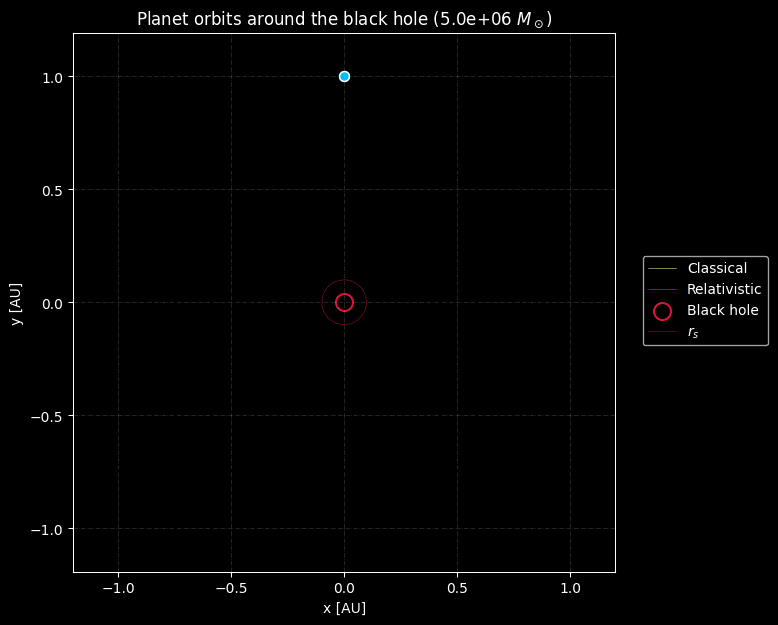

In [7]:
# Show it
painter.show_evolution("rel-vs-class.gif")

The relativity-corrected equations make the orbit show *precession*, while the classical does not. The contrast is considerable.

##### (j) Use the orbital history of both simulations to design a method that quantifies their differences and evaluates the importance of using the relativistic approach for massive objects. Do we need to worry about the relativistic corrections if we replace the black hole with our Sun?


---
**Quantitative analysis**

We will see how much the distance with respect to the massive object and velocity differ *on average* over the entire time evolution.

In [8]:
# Little function
def mean_euclidean(s1: np.ndarray, s2: np.ndarray) -> tuple:
    """
    It calculates the mean Euclidean distance and velocity between
    two solutions, [x, y, vx, vy] in AU and AU/yr, respectively.

    Parameters
    ----------
    s1 : array
        First solution.
    s2 : array
        Second solution.

    Returns
    -------
    mean_distance : float
        Mean distance difference.
    mean_velocity : float
        Mean velocity difference.
    """
    # Extract positions and velocities
    pos1 = s1[0:2, :]
    pos2 = s2[0:2, :]
    vel1 = s1[2:4, :]
    vel2 = s2[2:4, :]

    # Magnitude of velocities
    v1_mag = np.linalg.norm(vel1, axis = 0) 
    v2_mag = np.linalg.norm(vel2, axis = 0)

    # Calculate the mean differences
    mean_distance = np.mean(np.linalg.norm(pos1 - pos2, axis = 0)) # AU
    mean_velocity = np.mean(np.abs(v1_mag - v2_mag))               # AU/yr

    return mean_distance, mean_velocity

In [9]:
# Compute it
mean_distance, mean_velocity = mean_euclidean(S_class, S_relat)

In [10]:
# Print
print("Relativistic vs. classical:")
print(f"Mean distance difference: {mean_distance:.2e} AU")
print(f"Mean velocity difference: {mean_velocity:.2e} AU/yr")

Relativistic vs. classical:
Mean distance difference: 1.28e+00 AU
Mean velocity difference: 2.48e+03 AU/yr


They differ by a large amount, which confirms the relativistic corrections are important for massive objects.

---

**Sun case**

The only change we have to do is set the mass to $1\,\rm M_\odot$ and the rest is the same.

In [11]:
# Sun
M_sun = 1 # Solar masses

# Create another instance
integrator2 = CelestialSeer(M_sun, a, e)

In [12]:
# Classical case
t_class2, S_class2, file_class_sun = integrator2.integrate(
    relativistic = False, 
    N = N, 
    method = 'RK3', 
    save_hdf5 = True)

# Relativistic case
t_relat2, S_relat2, file_relat_sun = integrator2.integrate(
    relativistic = True, 
    N = N, 
    method = 'RK3', 
    save_hdf5 = True)

Saved to outputfolder/M1.0e+00-a1.0-e0.000-class-RK3.h5.
Saved to outputfolder/M1.0e+00-a1.0-e0.000-relat-RK3.h5.


In [13]:
# Create another instance
painter2 = ChronoPainter(
    orbits = (file_class_sun, file_relat_sun),
    labels = ('Classical', 'Relativistic'),
    colors = ('khaki', 'magenta')
    )

In [14]:
# Animate
painter2.paint(
    gif_name = "rel-vs-class-sun.gif",
    frames = 75,
    duration = 0.5,
    dpi = 100
)

----------------------------------------------------------
                  STARTING GIF CREATION
----------------------------------------------------------
Saving 75 frames...
----------------------------------------------------------
Progress: 0% (0 images)
Progress: 9% (7 images)
Progress: 19% (14 images)
Progress: 28% (21 images)
Progress: 37% (28 images)
Progress: 47% (35 images)
Progress: 56% (42 images)
Progress: 65% (49 images)
Progress: 75% (56 images)
Progress: 84% (63 images)
Progress: 93% (70 images)
----------------------------------------------------------
All 75 frames saved to outputfolder/sketches.
----------------------------------------------------------
Assembling the GIF...
----------------------------------------------------------
GIF saved to outputfolder/rel-vs-class-sun.gif.
----------------------------------------------------------
All frames have been deleted.
----------------------------------------------------------
                   END OF GIF CREATION
-

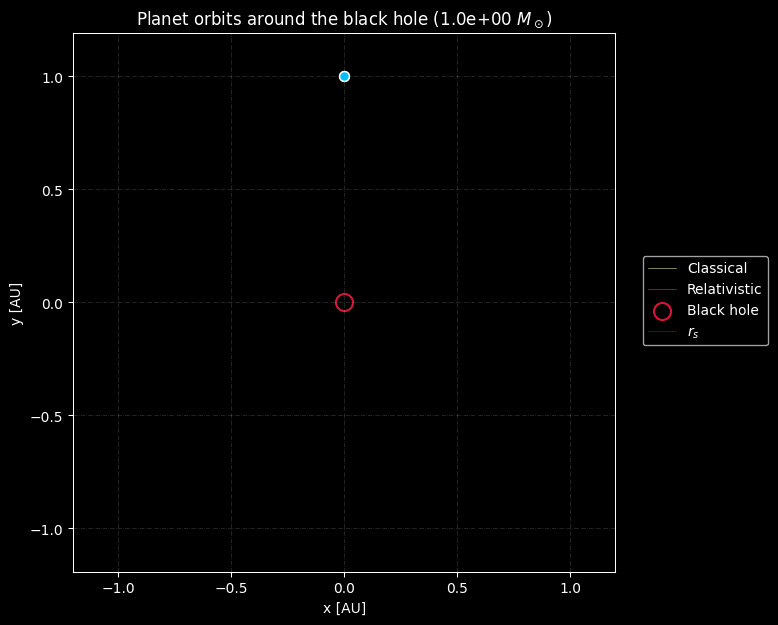

In [15]:
# Show it
painter2.show_evolution("rel-vs-class-sun.gif")

There does not seem to be a significant difference between the orbits when the mass is that of the Sun. The relativistic corrections seem to be negligible. To be sure, we'll use our quantitative analysis.

In [16]:
# Call the function
mean_distance2, mean_velocity2 = mean_euclidean(S_class2, S_relat2)

In [17]:
# Print
print("Relativistic vs. classical (Sun):")
print(f"Mean distance difference: {mean_distance2:.2e} AU")
print(f"Mean velocity difference: {mean_velocity2:.2e} AU/yr")

Relativistic vs. classical (Sun):
Mean distance difference: 3.75e-07 AU
Mean velocity difference: 1.86e-07 AU/yr


Since the mean differences are very small (around $56\rm\,km$ and $8.8\rm \, km/s$), we can effectively say that the relativistic corrections are negligible for the Sun.

### The role of eccentricity (3 points):

##### (k) Use your module/script to run and show three relativistic simulations for objects with different eccentricities, $e$, and assuming the same $M$, $a$, $N$ as above. It may be helpful to compare the orbital history for all values of $e$ in a single plot throughout time.

| Object           | Eccentricity ($e$) | Integration Method |
|------------------|--------------------|--------------------|
| Earth            | 0.01671            | Trapezoidal        |
| Pluto            | 0.25               | Trapezoidal        |
| 7092 Cadmus      | 0.70               | Trapezoidal        |

In [18]:
# Define eccentricities
e_earth  = 0.01671
e_pluto  = 0.25
e_cadmus = 0.70

In [19]:
# Create instances
earth_sys  = CelestialSeer(M, a, e_earth)
pluto_sys  = CelestialSeer(M, a, e_pluto)
cadmus_sys = CelestialSeer(M, a, e_cadmus)

# Integrate all
t_earth, S_earth, file_earth = earth_sys.integrate(
    relativistic = True, 
    N = N, 
    method = 'RK3', 
    save_hdf5 = True)

t_pluto, S_pluto, file_pluto = pluto_sys.integrate(
    relativistic = True, 
    N = N, 
    method = 'RK3',
    save_hdf5 = True)

t_cadmus, S_cadmus, file_cadmus = cadmus_sys.integrate(
    relativistic = True, 
    N = N, 
    method = 'RK3', 
    save_hdf5 = True)

Saved to outputfolder/M5.0e+06-a1.0-e0.017-relat-RK3.h5.
Saved to outputfolder/M5.0e+06-a1.0-e0.250-relat-RK3.h5.
Saved to outputfolder/M5.0e+06-a1.0-e0.700-relat-RK3.h5.


In [20]:
# Create instance
painter3 = ChronoPainter(
    orbits = (file_earth, file_pluto, file_cadmus),
    labels = (r'Earth, $e = 0.0167$', r'Pluto, $e = 0.25$', r'Cadmus, $e = 0.70$'),
    colors = ('khaki', 'magenta', 'white')
    )

In [21]:
# Animate
painter3.paint(
    gif_name = "diff_eccentricities.gif",
    frames = 75,
    duration = 0.5,
    dpi = 100
)

----------------------------------------------------------
                  STARTING GIF CREATION
----------------------------------------------------------
Saving 75 frames...
----------------------------------------------------------
Progress: 0% (0 images)
Progress: 9% (7 images)
Progress: 19% (14 images)
Progress: 28% (21 images)
Progress: 37% (28 images)
Progress: 47% (35 images)
Progress: 56% (42 images)
Progress: 65% (49 images)
Progress: 75% (56 images)
Progress: 84% (63 images)
Progress: 93% (70 images)
----------------------------------------------------------
All 75 frames saved to outputfolder/sketches.
----------------------------------------------------------
Assembling the GIF...
----------------------------------------------------------
GIF saved to outputfolder/diff_eccentricities.gif.
----------------------------------------------------------
All frames have been deleted.
----------------------------------------------------------
                   END OF GIF CREATIO

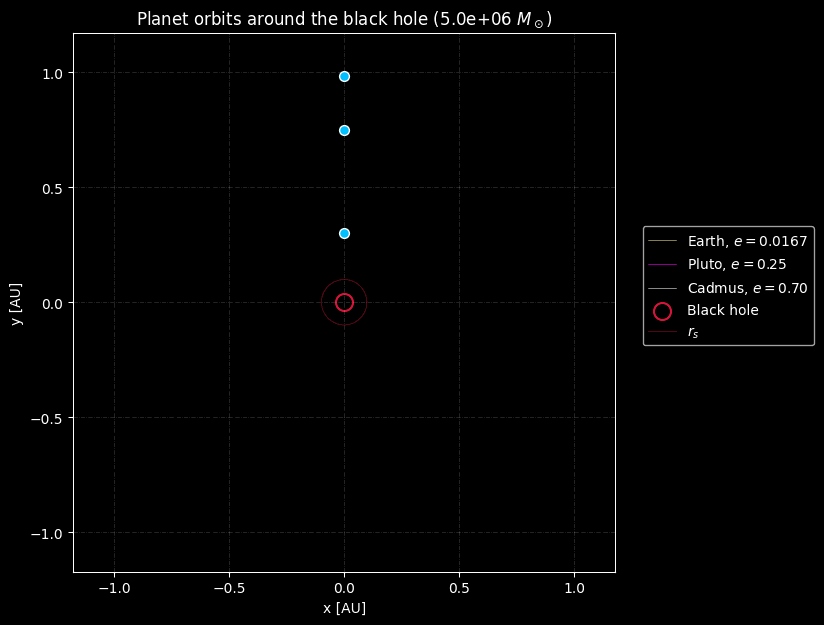

In [22]:
# Show it
painter3.show_evolution("diff_eccentricities.gif")

##### (l) Describe the differences in the orbits of the above objects. What happens to objects with high eccentricities?

The trajectories are quite different: Earth's orbit precesses, Pluto's remains strangely circular, and Cadmus' falls very rapidly towards the black hole. The distance of each object to the black hole is also different, with Cadmus being the closest.

I can think of two reasons for such different behaviors:

1. The initial conditions are calculated using the eccentricity, so they change per object. The position in $y$ and the velocity in $x$ are the ones that differ:

$$y_0 = a\,(1-e),$$

$$v_{x0} = -\sqrt{\frac{G\,M}{a}\frac{1+e}{1-e}}.$$

2. The relativistic corrections and $M = 5\times 10^6\,\rm M_\odot$ drastically change the expected (for me) elliptical shape of the orbits. Smaller masses and classical mechanics would have displayed the expected elliptical orbits.

In this case, objects with high eccentricities are closer to the black hole and more susceptible to its effects.

### Numerical convergence (3 points):

##### (m) Use your script to generate additional simulations with the same initial conditions as before, but only for $e=0.01671$ (Earth's eccentricity) with RK3, the Trapezoidal method and the higher-order SciPy integrator. Compare the orbital history for all methods in a single plot throughout time.

**Note:** We are going to use $N = 20$ because $N = 2$ didn't show any differences.

In [23]:
# Trapezoidal (we can reuse an instance defined before)
t_earth_tpz, S_earth_tpz, file_tpz = earth_sys.integrate(
    relativistic = True, 
    N = 20.0, 
    method = 'TPZ', 
    save_hdf5 = True)

# Runge-Kutta 3
t_earth_rk3, S_earth_rk3, file_rk3 = earth_sys.integrate(
    relativistic = True, 
    N = 20.0, 
    method = 'RK3', 
    save_hdf5 = True)

# Scipy
t_earth_spy, S_earth_spy, file_spy = earth_sys.integrate(
    relativistic = True, 
    N = 20.0, 
    method = 'SPY', 
    save_hdf5 = True)

Saved to outputfolder/M5.0e+06-a1.0-e0.017-relat-TPZ.h5.
Saved to outputfolder/M5.0e+06-a1.0-e0.017-relat-RK3.h5.
Saved to outputfolder/M5.0e+06-a1.0-e0.017-relat-SPY.h5.


In [24]:
# Create instance
painter4 = ChronoPainter(
    orbits = (file_earth, file_tpz, file_spy),
    labels = ('RK3', 'TPZ', 'SPY'),
    colors = ('khaki', 'magenta', 'white')
    )

In [25]:
# Animate
painter4.paint(
    gif_name = "diff_methods.gif",
    frames = 125,
    duration = 2.0,
    dpi = 100
)

----------------------------------------------------------
                  STARTING GIF CREATION
----------------------------------------------------------
Saving 125 frames...
----------------------------------------------------------
Progress: 0% (0 images)
Progress: 10% (12 images)
Progress: 19% (24 images)
Progress: 29% (36 images)
Progress: 38% (48 images)
Progress: 48% (60 images)
Progress: 58% (72 images)
Progress: 67% (84 images)
Progress: 77% (96 images)
Progress: 86% (108 images)
Progress: 96% (120 images)
----------------------------------------------------------
All 125 frames saved to outputfolder/sketches.
----------------------------------------------------------
Assembling the GIF...
----------------------------------------------------------
GIF saved to outputfolder/diff_methods.gif.
----------------------------------------------------------
All frames have been deleted.
----------------------------------------------------------
                   END OF GIF CREATION

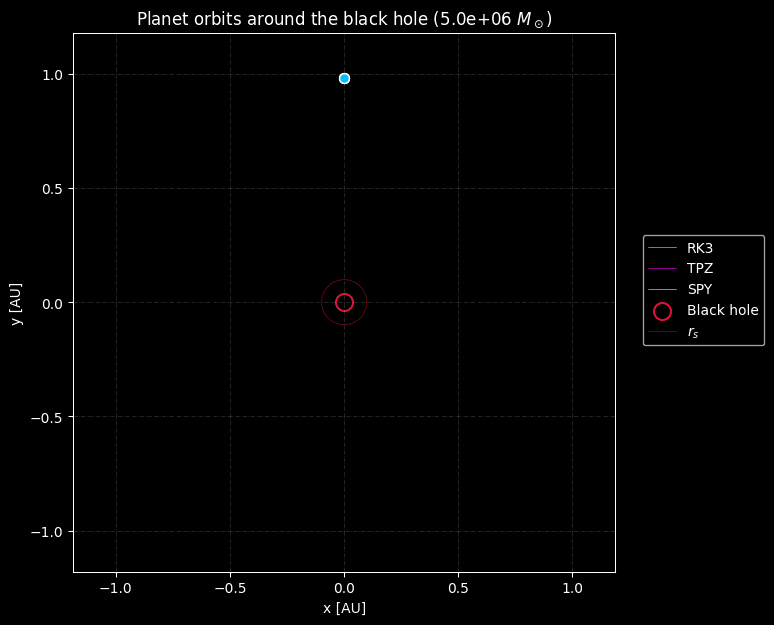

In [26]:
# Show it
painter4.show_evolution("diff_methods.gif")

The methods return very similar results, but after some time they do start separating. This separation seems to increase over time. Nonetheless, the orbits follow similar paths and tendencies. 

##### (n) Measure convergence of the simulations with RK3 and Trapezoidal method for $e=0.01671$ by integrating at a number of different time steps. To analyse convergence, you need to define some measure for the error with respect to the higher order method, and then plot it against different time steps for both methods. Thus, you may add additional functions for this to your code in **orbits.py**. 

Our implementation takes the number of steps and uses it to internally define the step size. As such, the main method for measuring convergence has the number of steps to be used as an argument, which is equivalent to varying the step size. The error is then computed using the mean Euclidean distance between the solution with a higher order method.

In [27]:
# We can reuse the same instance as before
step, error_rk3, powerlaw_rk3 = earth_sys.measure_convergence(
    N = 2.0,
    method = 'RK3',
    relativistic = True,
    num_steps = (500, 400, 300, 200, 100)
)

_, error_tpz, powerlaw_tpz = earth_sys.measure_convergence(
    N = 2.0,
    method = 'TPZ',
    relativistic = True,
    num_steps = (500, 400, 300, 200, 100)
)

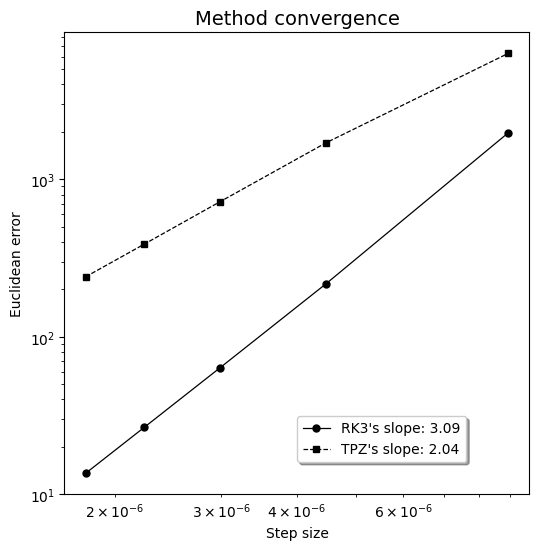

In [28]:
# Plot
plt.figure(figsize=(6, 6))

plt.plot(step, error_rk3, label = f"RK3's slope: {powerlaw_rk3:.2f}",
         ls = "-", c = "k", marker = "o", markersize = 5, lw = 0.9)
plt.plot(step, error_tpz, label = f"TPZ's slope: {powerlaw_tpz:.2f}",
         ls = "--", c = "k", marker = "s", markersize = 5, lw = 0.9)

plt.loglog()

plt.xlabel("Step size")
plt.ylabel("Euclidean error")
plt.title("Method convergence", fontsize = 14)

plt.legend(frameon = True, shadow = True, fontsize = 10, loc = (0.5,0.07))
plt.show()

The results are in accordance with the expected orders of error. This confirms our methods are well-implemented.

---
That's it, thank you for designing the exam, prof. Wladimir :).

---